This notebook contains an example showing the calculation of a marginal confidence interval for the equilibrium dissociation constant Kd

It is based on the work published at Paketurytė, V., Petrauskas, V., Zubrienė, A., Abian, O., Bastos, M., Chen, W. Y., ... & Matulis, D. (2021). Uncertainty in protein–ligand binding constants: asymmetric confidence intervals versus standard errors. European Biophysics Journal, 50(3), 661-670.

In [29]:
import numpy as np
from fitting import calc_one_to_one_binding_signal, fit_one_to_one_signal, calc_asymmetric_conf_interval, calc_rss_of_fitting_fixed_Kd
from stats import calculate_rss_limit

import matplotlib.pyplot as plt

Create a fake dataset showing the signal of a protein-ligand interaction

P + L <-> PL

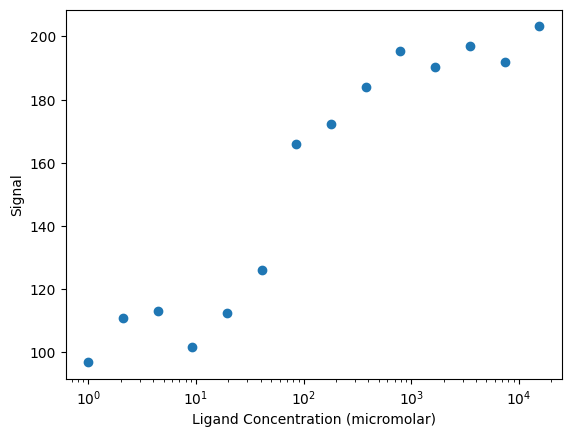

In [30]:
lig_conc = 2.1**np.arange(14)
prot_conc = 2
Kd = 70

free_protein_signal = 50
complex_signal = 100

signal = calc_one_to_one_binding_signal(lig_conc,prot_conc,Kd,free_protein_signal,complex_signal)

# Set a seed
np.random.seed(44)

# add gaussian noise
signal += np.random.normal(0,6,len(signal))

plt.plot(lig_conc,signal,'o')
plt.xscale('log')
plt.xlabel('Ligand Concentration (micromolar)')
plt.ylabel('Signal')
plt.show()

Fit the dataset

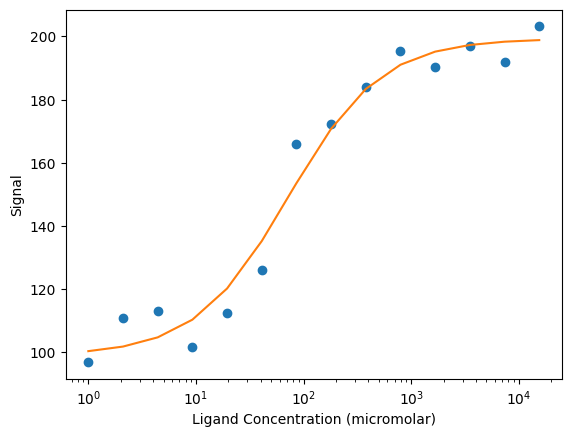

The fitted parameters are:
[71.  49.5 99.6]


In [31]:
fit, rel_error, fitted_signal = fit_one_to_one_signal(signal,l,p)

plt.plot(lig_conc,signal,'o')
plt.plot(lig_conc, fitted_signal)
plt.xscale('log')
plt.xlabel('Ligand Concentration (micromolar)')
plt.ylabel('Signal')
plt.show()

print('The fitted parameters are:')
print(np.round(fit,1))

Now we compute the marginal confidence interval

In [32]:
ci95_low,ci95_up = calc_asymmetric_conf_interval(
    signal,
    fitted_signal,
    lig_conc,
    prot_conc,
    Kd,
    fit[1],
    fit[2],
    3 # Number of parameters
)

ci95_low = np.round(ci95_low,1)
ci95_up = np.round(ci95_up,1)

print('The lower CI95 for the Kd is: {}'.format(ci95_low))
print('The upper CI95 for the Kd is: {}'.format(ci95_up))

The lower CI95 for the Kd is: 43.2
The upper CI95 for the Kd is: 117.3


Now we can also compute the asymmetric confidence interval "by hand"

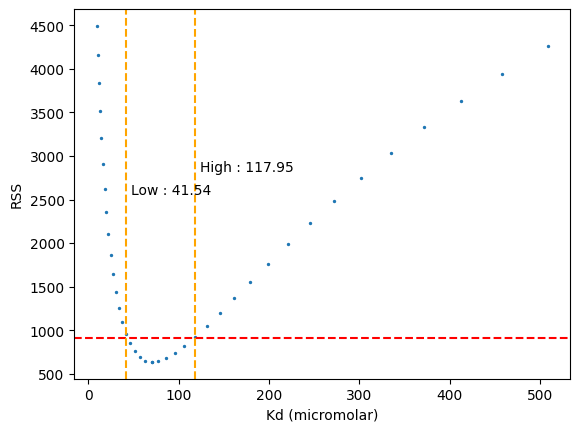

In [39]:
rss_threshold = calculate_rss_limit(signal,fitted_signal,3,0.05)

kd_to_explore_1 = Kd * (1.11**np.arange(20))
kd_to_explore_2 = Kd * 1/(1.11**np.arange(20))

rss_1_all = []
rss_2_all = []

kd_low_limit = None
kd_high_limit = None

for kd_1,kd_2 in zip(kd_to_explore_1,kd_to_explore_2):

    rss_1 = calc_rss_of_fitting_fixed_Kd(signal,lig_conc,prot_conc,kd_1,fit[1:])
    rss_2 = calc_rss_of_fitting_fixed_Kd(signal,lig_conc,prot_conc,kd_2,fit[1:])

    if kd_low_limit is None and rss_2 > rss_threshold:
        kd_low_limit = kd_2

    if kd_high_limit is None and rss_1 > rss_threshold:
        kd_high_limit = kd_1

    rss_1_all.append(rss_1)
    rss_2_all.append(rss_2)

rss_all = rss_1_all + rss_2_all
Kd_all  = np.concatenate((kd_to_explore_1,kd_to_explore_2))

plt.scatter(Kd_all,rss_all,s=2)
plt.xlabel("Kd (micromolar)")
plt.ylabel("RSS")
# increase font size
# horizontal dashed at rss threshold
plt.axhline(y=rss_threshold, color='r', linestyle='--')

# vertical lines at kd_low_limit and kd_high_limit
plt.axvline(x=kd_low_limit, color='orange', linestyle='--')
plt.axvline(x=kd_high_limit, color='orange', linestyle='--')

max_rss = np.max(rss_all)
min_rss = np.min(rss_all)
label_y_pos = (max_rss - min_rss) * 0.5 + min_rss

# add the values of the Kd limits
plt.text(kd_low_limit+kd_high_limit*0.05,label_y_pos,"Low : {:.2f}".format(kd_low_limit))
plt.text(kd_high_limit*1.05,label_y_pos*1.1,"High : {:.2f}".format(kd_high_limit))

plt.show()